<a href="https://colab.research.google.com/github/Allisonhanna/Projects/blob/main/lotifno_remove_duplicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключаем pandas для работы с датафреймом, seaborn для визуализации, glob для работы со всеми файлами, chardet для определения кодировки файла

In [ ]:
import pandas as pd
import seaborn as sns
import glob
import chardet

Через file_paths получаем названия всех файлов. Фиксируем кодировку изначальных файлов в encoding

In [ ]:
file_paths = glob.glob('*.csv')
encoding = 'windows-1251'

Фиксируем интересующие нас источники в переменную

In [ ]:
allowed_sources = ['avito.ru', 'cian.ru']

Эмпирическим путем были выбраны 2 списка из столбцов, для создания уникального ID

In [1]:
selected_columns_1 = ['Статус', 'Улица+дом+корпус', 'Этаж расположения',
                      'Первоначальная цена, руб.', 'Общая площадь, кв. м', 'Год']
selected_columns_2 = ['Статус', 'Улица+дом+корпус', 'Этаж расположения',
                      'Цена за объект (последняя выставленна цена), руб.',
                      'Общая площадь, кв. м', 'Год']

Нужны были данные только по Северным городам. В дата-сете есть координаты каждого объекта из объявления. Чтобы избавиться от выбросов, прогоняю через функцию ниже. Согласовал с подрядчиком координаты из карты ниже

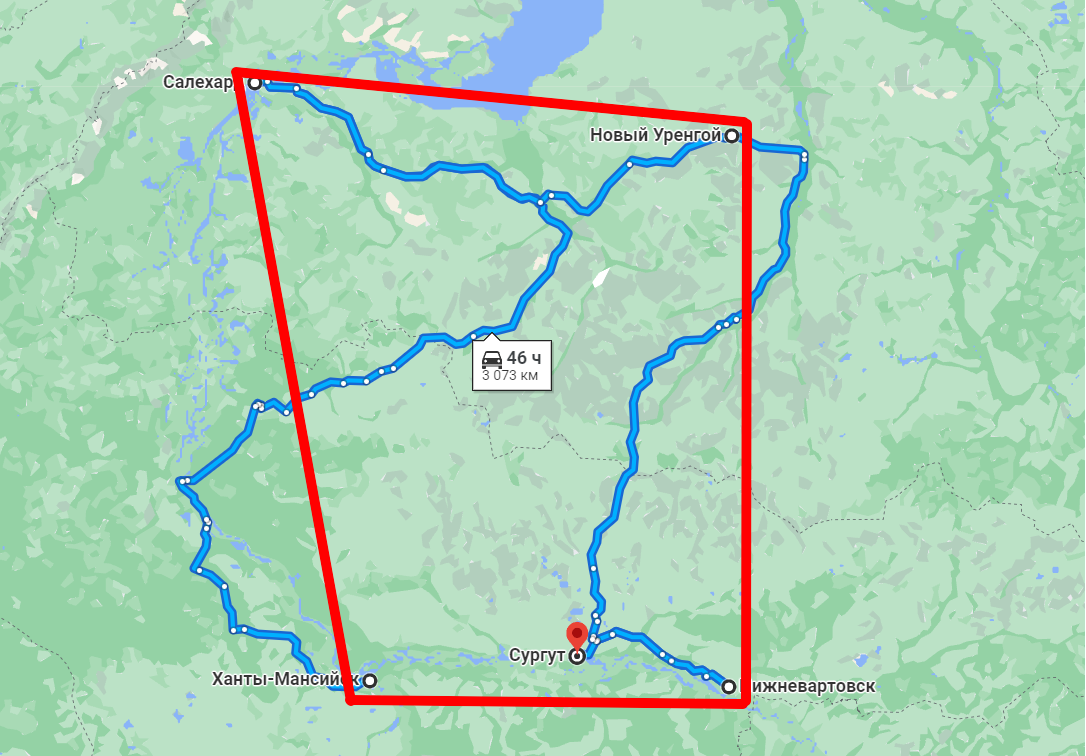

In [ ]:
def check_point(y, x):
    if (x >= 65.12 and x <= 78.0) and (y >= 60.42 and y <= 67.0):
        return True
    else:
        return False

Основная задача, склеить это всё в один чистый дата-сет. Ниже через цикл, добавляем столбцы City, Type_, status, year. Очищаем датасет от дублей через drop_duplicates по нашими сформированными Уникальными ID

In [ ]:
combined_df = pd.DataFrame()

for file_path in file_paths:
    list_name = file_path.replace('.', ',').split(',')

    city = list_name[0]
    type_ = list_name[1]
    status = list_name[2]
    year = list_name[3]

    df = pd.read_csv(file_path, encoding=encoding, sep=';')
    df.rename(columns=df.iloc[0], inplace=True)
    df.drop([0, 1], axis=0, inplace=True)
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)

    df['Статус'] = status
    df['Тип помещения'] = type_
    df['Город'] = city
    df['Год'] = year

    df['Уникальный_ID_status1'] = df[selected_columns_1].apply(lambda row: ''.join(str(x) for x in row), axis=1)
    df['Уникальный_ID_status2'] = df[selected_columns_2].apply(lambda row: ''.join(str(x) for x in row), axis=1)


    df.drop_duplicates(subset='Уникальный_ID_status1', keep='first', inplace=True)
    df.drop_duplicates(subset='Уникальный_ID_status2', keep='first', inplace=True)

    df = df[df['Источник информации'].isin(allowed_sources)]

    df['X'] = df['Х координата'].str.replace(',', '.').astype(float)
    df['Y'] = df['У координата'].str.replace(',', '.').astype(float)

    df['Находится ли в зоне'] = df.apply(lambda row: check_point(row['X'], row['Y']), axis=1)
    df = df[df['Находится ли в зоне']==True]

    combined_df = pd.concat([combined_df, df], ignore_index=True)

/var/folders/_t/dx9cq7yx39j57lpj4kbqn25h0000gn/T/ipykernel_869/1705166657.py:11: DtypeWarning: Columns (6,13,15,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding, sep=';')
/var/folders/_t/dx9cq7yx39j57lpj4kbqn25h0000gn/T/ipykernel_869/1705166657.py:11: DtypeWarning: Columns (6,13,15,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding, sep=';')
/var/folders/_t/dx9cq7yx39j57lpj4kbqn25h0000gn/T/ipykernel_869/1705166657.py:11: DtypeWarning: Columns (6,13,15,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding, sep=';')
/var/folders/_t/dx9cq7yx39j57lpj4kbqn25h0000gn/T/ipykernel_869/1705166657.py:11: DtypeWarning: Columns (6,13,15,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv

In [ ]:
combined_df.shape

(110750, 40)

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110750 entries, 0 to 110749
Data columns (total 40 columns):
 #   Column                                                                Non-Null Count   Dtype  
---  ------                                                                --------------   -----  
 0   Источник информации                                                   110750 non-null  object 
 1   Дата первого нахождения объявления в источнике                        110750 non-null  object 
 2   Дата последней проверки объявления в источнике                        110750 non-null  object 
 3   ID (идентификационный номер) в источнике                              110750 non-null  object 
 4   ID (идентификационный номер) на сайте www.lotinfo.ru                  110750 non-null  object 
 5   Назначение объекта                                                    110750 non-null  object 
 6   Количество комнат                                                     105890 non-nul

Преобразуем данные для поиска удельной стоимости. Также убираем выбросы. Здесь данные давал заказчик от удельной стоимости

In [ ]:
combined_df['Общая площадь, кв. м'] = combined_df['Общая площадь, кв. м'].apply(lambda x: x.replace(',',  '.'))

In [ ]:
combined_df['Общая площадь, кв. м'] = combined_df['Общая площадь, кв. м'].apply(lambda x: float(x))

In [ ]:
combined_df['Цена за объект (последняя выставленна цена), руб.'] = combined_df['Цена за объект (последняя выставленна цена), руб.'].apply(lambda x: int(x))

In [ ]:
combined_df['Удельная стоимость'] = combined_df['Цена за объект (последняя выставленна цена), руб.'] / combined_df['Общая площадь, кв. м']

In [ ]:
combined_df['Удельная стоимость'] = combined_df['Удельная стоимость'].apply(lambda x: float(x))

In [ ]:
combined_df = combined_df[combined_df['Удельная стоимость'] < 250000]

In [ ]:
combined_df = combined_df[combined_df['Удельная стоимость'] > 59000]

In [ ]:
combined_df.shape

(97976, 41)

Выводим чистый дата-сет в csv

In [ ]:
combined_df.to_csv('result_1.csv', sep=';', index=False)

In [ ]:
combined_df.columns

Index(['Источник информации', 'Дата первого нахождения объявления в источнике',
       'Дата последней проверки объявления в источнике',
       'ID (идентификационный номер) в источнике',
       'ID (идентификационный номер) на сайте www.lotinfo.ru',
       'Назначение объекта', 'Количество комнат', 'Адрес по объявлению',
       'Улица', 'Улица+дом+корпус', 'Район города', 'Х координата',
       'У координата', 'Год ввода в экспуатацию по объявлению',
       'Тип стен дома  (материал основных несущих конструкций) по объявлению',
       'Этаж расположения', 'Этажность', 'Ремонт',
       'Цена за объект (последняя выставленна цена), руб.',
       'Первоначальная цена, руб.', 'Общая площадь, кв. м',
       'Жилая площадь, кв. м', 'Кухня, кв. м', 'Студия, кв. м',
       'Комнаты (смежные/изолированные)', 'Санузел', 'Текст объявления',
       'Прямая ссылка на источник информации',
       'Ссылка на хранилице на www.9xc.ru', 'Контактные данные', 'Статус',
       'Тип помещения', 'Город', 'Г